In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-27 12:07:43 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-27 12:07:43 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-27 12:07:43 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-27 12:07:56 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-27 12:07:56 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-27 12:07:56 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-27 12:07:56 wandb.docker.auth DEBUG    No config file found


In [7]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [8]:
# HEADS = [
#     (33, 45),
#     (33, 18),
#     (34, 1),
#     (34, 6),
#     (34, 7),
#     (35, 19),
#     (39, 40),
#     (42, 30),
#     (47, 18),
#     (52, 58),
# ]

HEADS = [(62, 1), (60, 9), (64, 8), (62, 0), (62, 45), (59, 59), (71, 28), (64, 12), (61, 7), (64, 13), (67, 53), (67, 51), (54, 44), (57, 5), (59, 60)]

# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]


print(len(HEADS))

15


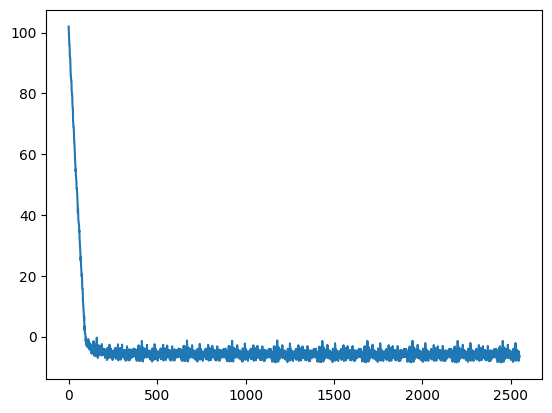

In [11]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    # "distinct_options",
    f"{select_task.task_name}",
    "epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

80


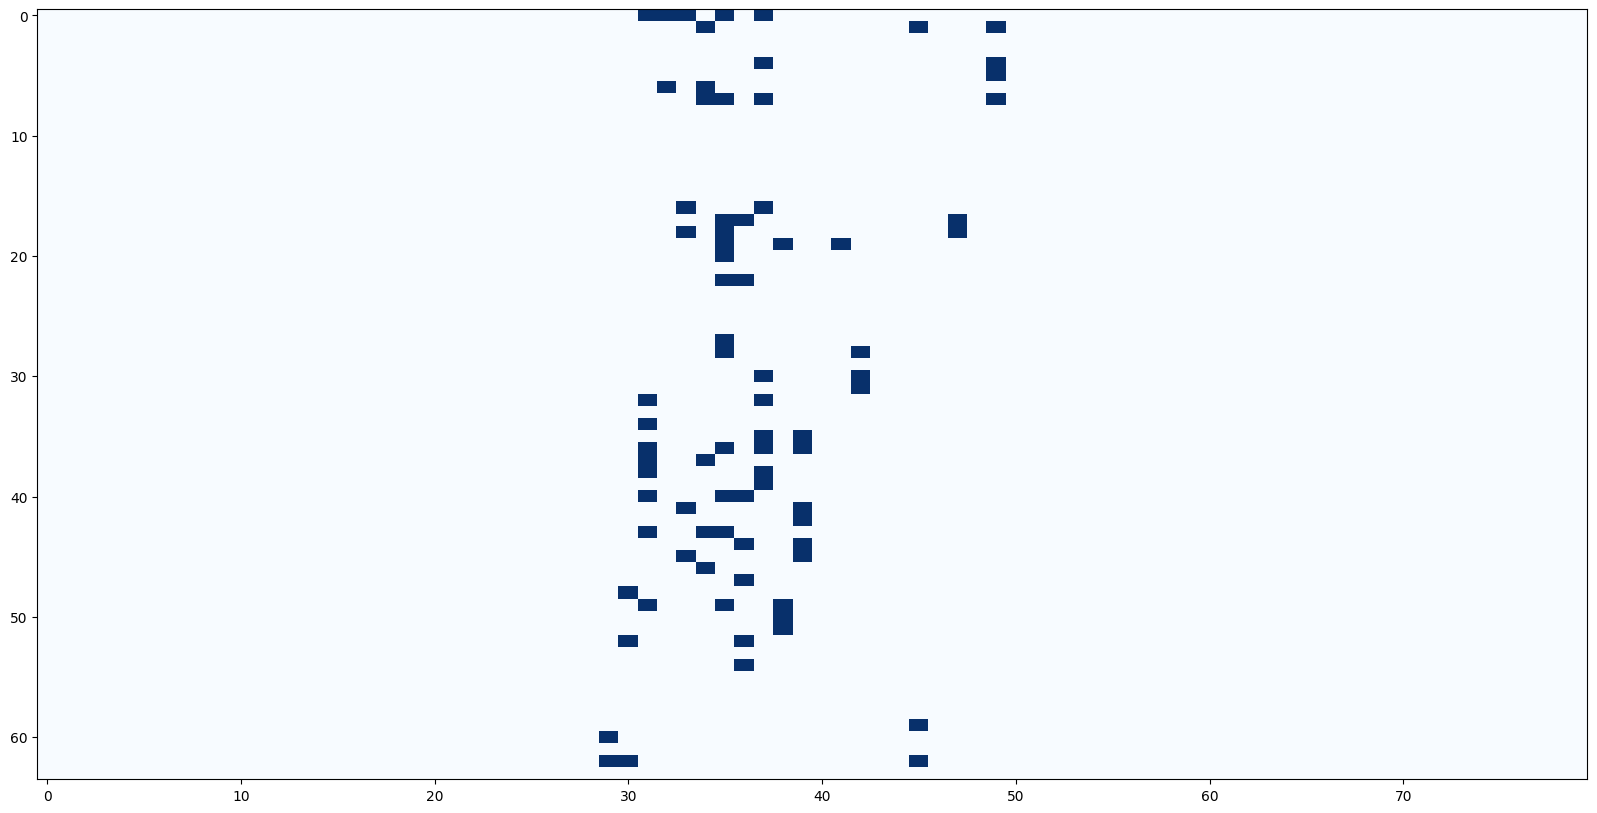

In [12]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected
]
print(len(heads_selected))

# HEADS = heads_selected

# (35, 19) in HEADS, (35, 19) in heads_selected

## Loading the Attention Behavior Results

In [ ]:
from scripts.locate_via_attention_behavior import SelectionSampleAttn

attn_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/attention_patterns/select_one",
    model_key.split("/")[-1],
    "objects"
)
files = sorted(os.listdir(attn_path))
print(files)

#######################################################################
# LIMIT = 100
LIMIT = len(files)
#######################################################################

selection_attns = []

for npz_file in files[:LIMIT]:
    if not npz_file.endswith(".npz"):
        continue

    npz_path = os.path.join(attn_path, npz_file)
    selection_attns.append(SelectionSampleAttn.from_npz(npz_path))
    if len(selection_attns) % 100 == 0:
        print(f"Loaded {len(selection_attns)}/{LIMIT} files")

len(selection_attns), selection_attns[0].attention_pattern.attention_matrices.shape

['sample_0000.npz', 'sample_0001.npz', 'sample_0002.npz', 'sample_0003.npz', 'sample_0004.npz', 'sample_0005.npz', 'sample_0006.npz', 'sample_0007.npz', 'sample_0008.npz', 'sample_0009.npz', 'sample_0010.npz', 'sample_0011.npz', 'sample_0012.npz', 'sample_0013.npz', 'sample_0014.npz', 'sample_0015.npz', 'sample_0016.npz', 'sample_0017.npz', 'sample_0018.npz', 'sample_0019.npz', 'sample_0020.npz', 'sample_0021.npz', 'sample_0022.npz', 'sample_0023.npz', 'sample_0024.npz', 'sample_0025.npz', 'sample_0026.npz', 'sample_0027.npz', 'sample_0028.npz', 'sample_0029.npz', 'sample_0030.npz', 'sample_0031.npz', 'sample_0032.npz', 'sample_0033.npz', 'sample_0034.npz', 'sample_0035.npz', 'sample_0036.npz', 'sample_0037.npz', 'sample_0038.npz', 'sample_0039.npz', 'sample_0040.npz', 'sample_0041.npz', 'sample_0042.npz', 'sample_0043.npz', 'sample_0044.npz', 'sample_0045.npz', 'sample_0046.npz', 'sample_0047.npz', 'sample_0048.npz', 'sample_0049.npz', 'sample_0050.npz', 'sample_0051.npz', 'sample_005

error: Error -3 while decompressing data: invalid code lengths set

In [51]:
from tqdm.auto import tqdm

#############################################################################
n_layer = selection_attns[0].attention_pattern.attention_matrices.shape[0]
n_head = selection_attns[0].attention_pattern.attention_matrices.shape[1]
# token_idx = "all"
token_idx = "last"
##############################################################################

resolution_scores = torch.zeros((n_head, n_layer), dtype=torch.float32)
for selection_attn in tqdm(selection_attns):
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            resolution_scores[head_idx, layer_idx] += selection_attn.resolution_score(
                layer_idx, head_idx, token_idx=token_idx
            )[0]
            # resolution_scores[head_idx, layer_idx] += selection_attn.first_token_score(
            #     layer_idx, head_idx
            # )[0]

resolution_scores /= len(selection_attns)
resolution_scores.shape

  0%|          | 0/202 [00:00<?, ?it/s]

torch.Size([64, 80])

2025-08-27 12:43:10 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ff4fa64d9d0>


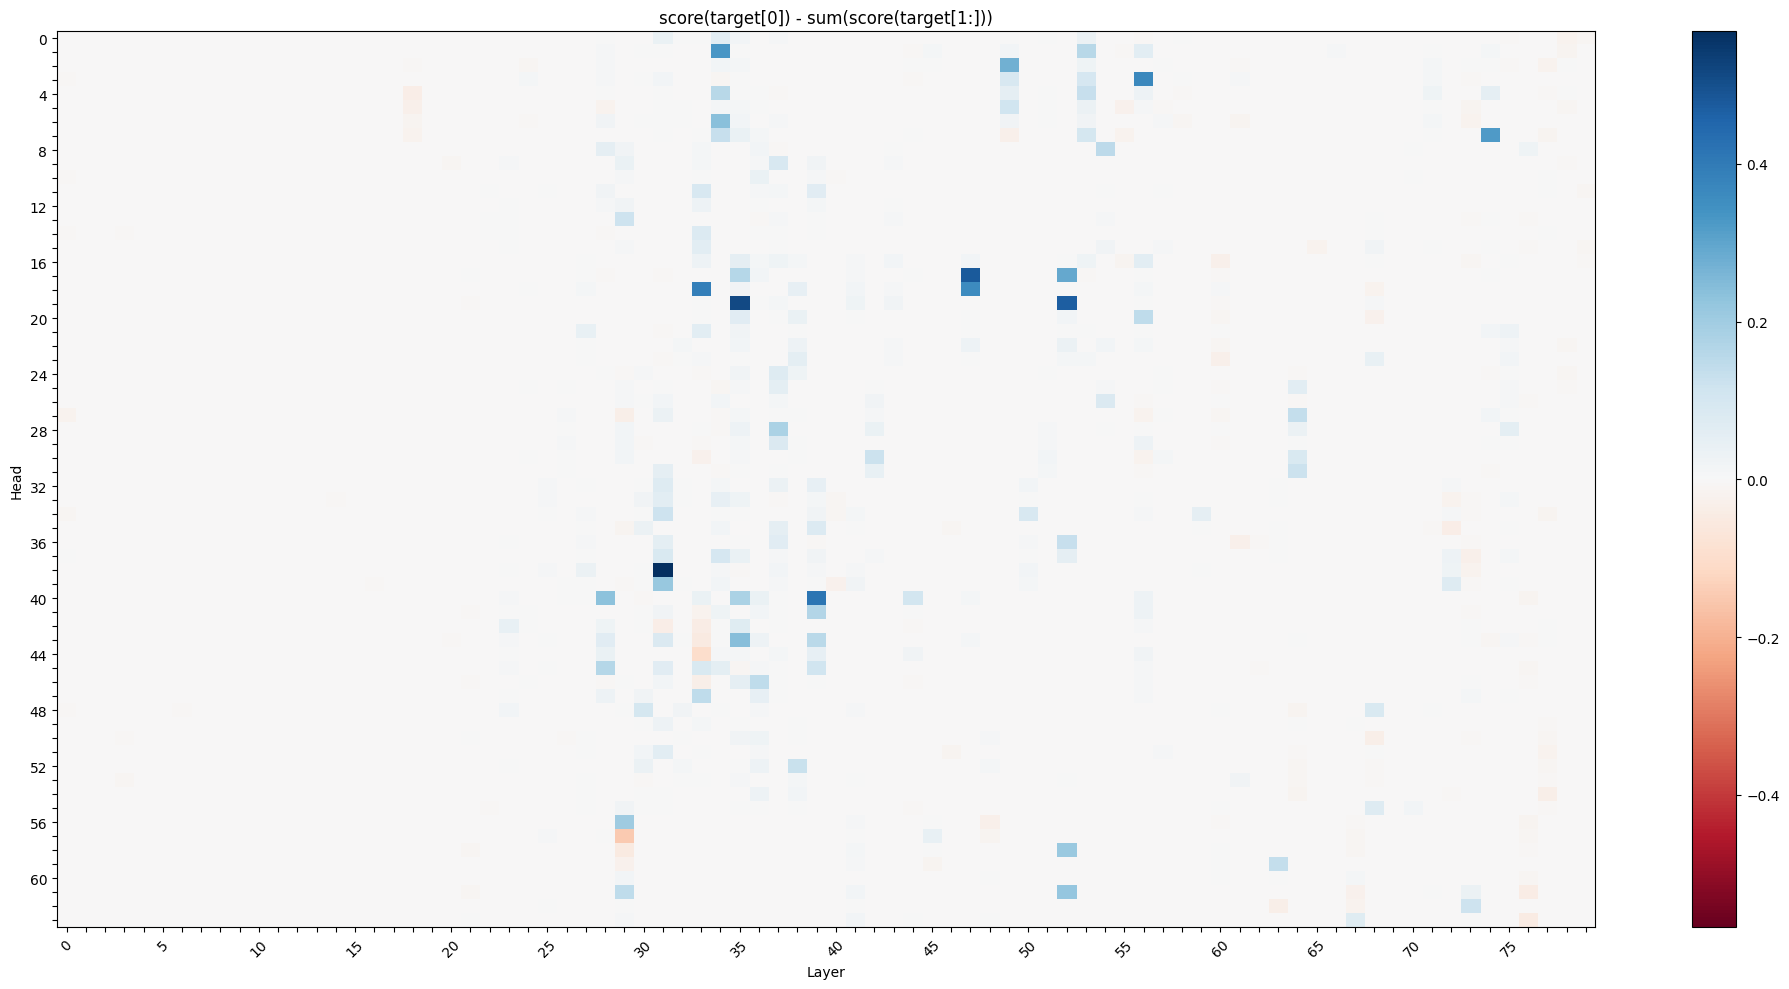

Layer 31, Head 38: 0.5681
Layer 35, Head 19: 0.5133
Layer 47, Head 17: 0.4783
Layer 52, Head 19: 0.4674
Layer 39, Head 40: 0.4135
Layer 33, Head 18: 0.3893
Layer 56, Head 3: 0.3680
Layer 47, Head 18: 0.3583
Layer 34, Head 1: 0.3327
Layer 74, Head 7: 0.3239
Layer 52, Head 17: 0.2922
Layer 49, Head 2: 0.2727
Layer 35, Head 43: 0.2399
Layer 34, Head 6: 0.2392
Layer 28, Head 40: 0.2329


In [53]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scale = torch.max(torch.abs(resolution_scores))
plt.imshow(
    resolution_scores.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    vmin=-scale,
    vmax=scale,
)
plt.colorbar()
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
plt.title("score(target[0]) - sum(score(target[1:]))")
plt.xlabel("Layer")
plt.ylabel("Head")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_head),
    labels=get_ticks(range(n_head), skip=4),
)

plt.tight_layout()
plt.show()


scores_per_head = []
for head_idx in range(n_head):
    for layer_idx in range(n_layer):
        scores_per_head.append(
            (head_idx, layer_idx, resolution_scores[head_idx, layer_idx].item())
        )

scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
for head_idx, layer_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

In [54]:
from src.attention import visualize_attn_matrix

sample_idx = 45
layer_idx = 35
head_idx = 19
# layer_idx = 54
# head_idx = 44

# selection_attn = selection_attns[sample_idx]
selection_attn = non_aligned[2]
print(selection_attn.resolution_score(layer_idx, head_idx))
visualize_attn_matrix(
    attn_matrix=selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx],
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1,
)

(-0.3720703125, 0.0927734375, [0.00994873046875, 0.0400390625, 0.46484375, 0.025665283203125, 0.035888671875])


In [55]:
selection_attn.score_per_option(35, 19)

[0.00994873046875,
 0.0927734375,
 0.0400390625,
 0.46484375,
 0.025665283203125,
 0.035888671875]

In [56]:
combined_attn_matrix = []
combined_option_scores = []
for layer_idx, head_idx in heads_selected:
    combined_attn_matrix.append(
        torch.Tensor(selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx])
    )
    combined_option_scores.append(
        selection_attn.score_per_option(layer_idx, head_idx)
    )

combined_attn_matrix = torch.stack(combined_attn_matrix).squeeze().mean(dim=0)

visualize_attn_matrix(
    attn_matrix=combined_attn_matrix,
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1
)

In [40]:
combined_option_scores = torch.Tensor(combined_option_scores)
combined_option_scores.mean(dim=0).argmax().item() == selection_attn.sample.obj_idx

True

In [43]:
aligned = []
non_aligned = []

for filter_attn_result in selection_attns:
    combined_option_scores = []
    for layer_idx, head_idx in heads_selected:
        combined_option_scores.append(
            filter_attn_result.score_per_option(layer_idx, head_idx)
        )
    combined_option_scores = torch.Tensor(combined_option_scores)
    if combined_option_scores.mean(dim=0).argmax().item() == filter_attn_result.sample.obj_idx:
        aligned.append(filter_attn_result)
    else:
        non_aligned.append(filter_attn_result)

f"Accuracy: {len(aligned) / (len(selection_attns)):.2f} ({len(aligned)} / {len(selection_attns)})"

'Accuracy: 0.95 (191 / 202)'